In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal as ss
from scipy import interpolate
from optparse import OptionParser
import time, os 
import imrtestgr as tgr
import pickle, gzip
import sys 
#import postproc
import scipy.stats as stats

In [2]:
# Module for confidence calculations
class confidence(object):
  def __init__(self, counts):
    # Sort in descending order in frequency
    self.counts_sorted = np.sort(counts.flatten())[::-1]
    # Get a normalized cumulative distribution from the mode
    self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
    # Set interpolations between heights, bins and levels
    self._set_interp()
  def _set_interp(self):
    self._length = len(self.counts_sorted)
    # height from index
    self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
    # index from height
    self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
    # level from index
    self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
    # index from level
    self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
  def level_from_height(self, height):
    return self._level_from_idx(self._idx_from_height(height))
  def height_from_level(self, level):
    return self._height_from_idx(self._idx_from_level(level))

def compte_kde(param1, param2, p1_vec, p2_vec): 

    # construct kde 
    P12_kde_obj = stats.gaussian_kde([param1, param2])
    P12_kde_fn = lambda x, y: P12_kde_obj.evaluate([x, y])
    param1_mat, param2_mat = np.meshgrid(p1_vec, p2_vec)
    P_12 = np.vectorize(P12_kde_fn)(param1_mat, param2_mat)

    # Marginalization to one-dimensional 
    d_v1 = np.mean(np.diff(p1_vec))
    d_v2 = np.mean(np.diff(p2_vec))
    P_v1 = np.sum(P_12, axis=0) * d_v2
    P_v2 = np.sum(P_12, axis=1) * d_v1

    # compute the 90% credible regions 
    conf_v1v2 = confidence(P_12)
    s2_v1v2 = conf_v1v2.height_from_level(0.9)

    return P_v1, P_v2, P_12, s2_v1v2

# Inputs

In [3]:
templ = 'SEOBNRv4_ROMpseudoFourPN'
t0_ref = 1187529256
col_vec = ['lawngreen','hotpink','k']
ms_vec = [2, 1.5, 0.5]
mc_vec = np.linspace(12.299703,150,100)
m_vec = np.linspace(3.91258703,858.96720526,800)

post_loc_clean = '/home/abhirup/Documents/Work/O2/2017/August/23/1187529256p5179/G298936/lalinference/Reruns/20180314_mcprior_150_dL_10000_SEOBNRv4_ROM_C02_LALPSD_seglen8_HL_scseg'
post_loc_unclean = '/home/abhirup/Documents/Work/O2/2017/August/23/1187529256p5179/G298936/lalinference/Reruns/20180314_mcprior_150_dL_10000_SEOBNRv4_ROM_C02_LALPSD_seglen8_HL_scseg_unclean'
post_loc = post_loc_clean

# Scatter plot of Mc and t0 

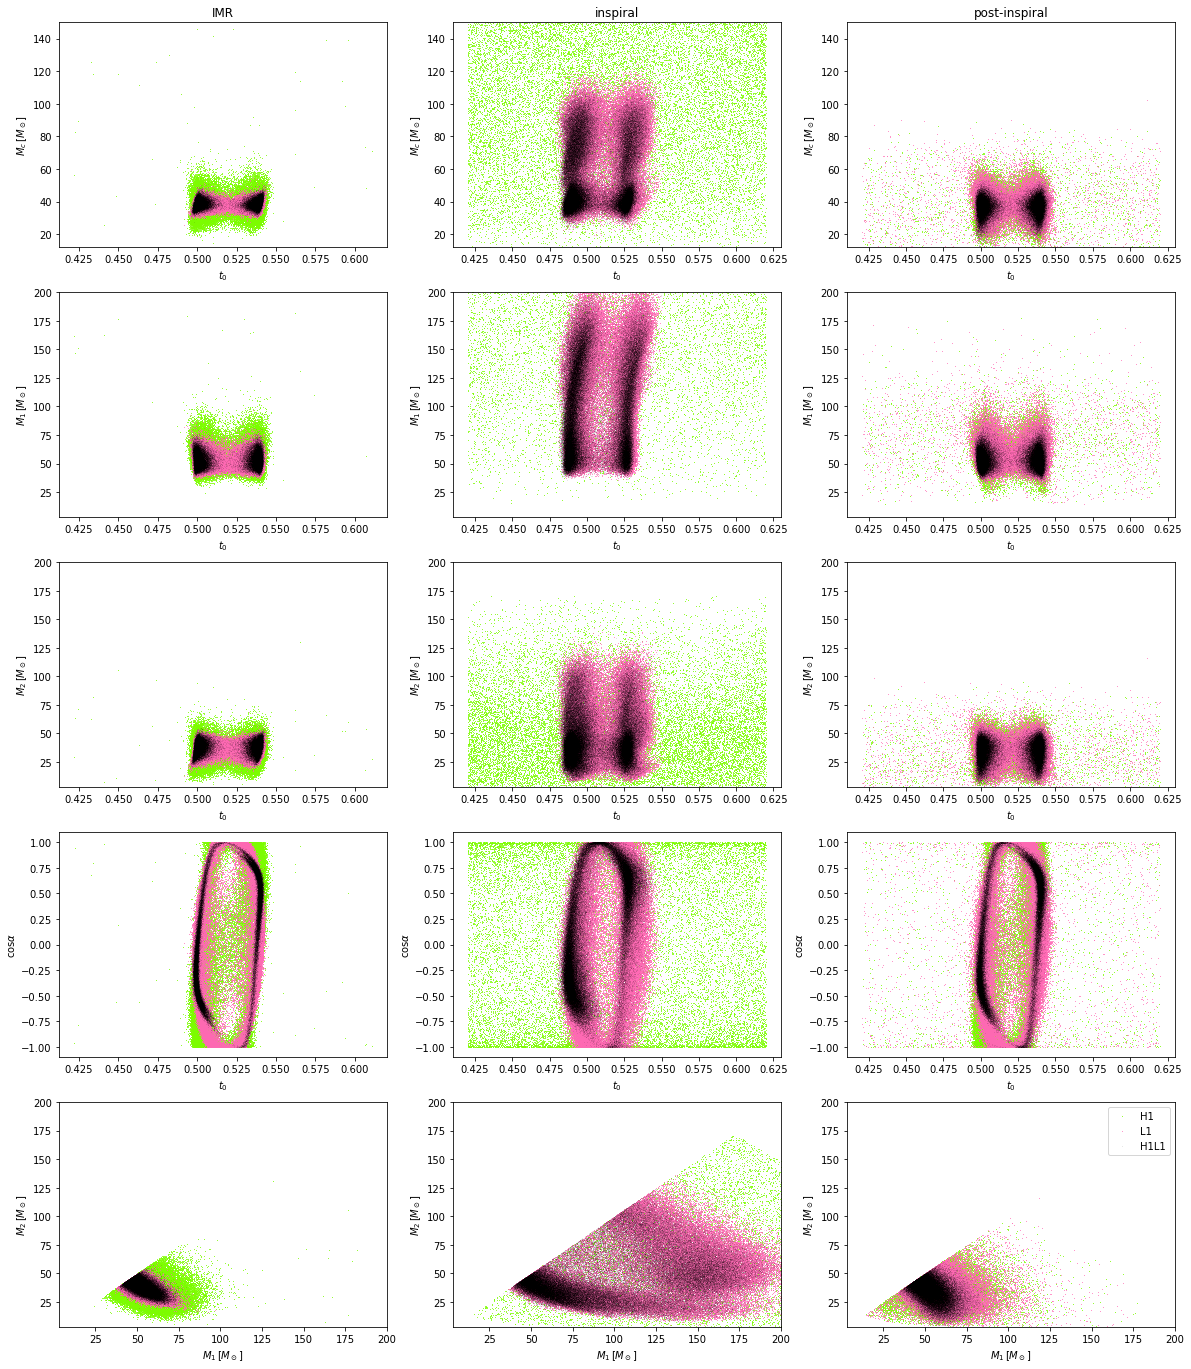

In [23]:
# make scatter plots 
plt.figure(figsize=(20,24))

for i_r, run in enumerate(['IMR', 'inspiral', 'post-inspiral']): 
    for i_d, det in enumerate(['H1', 'L1', 'H1L1']):
        if det == 'H1' or det == 'L1':
            post_file = post_loc + '/%s/lalinferencenest/%s/1187529256.52-0/H1L1/%s/posterior_samples.dat'%(run, templ, det)
        elif det == 'H1L1':
            post_file = post_loc + '/%s/lalinferencenest/%s/1187529256.52-0/H1L1/posterior_samples.dat'%(run, templ)
        data = np.genfromtxt(post_file, dtype=None, names=True)
        m1, m2, dlogL, logL, t0, ra, dec = data['m1'], data['m2'], data['deltalogl'], data['logl'], data['time'], data['ra'], data['dec']
        
        m_tot = m1+m2 
        q = m1/m2 
        eta = q/(1.+q)**2 
        m_c = m_tot*eta**(3./5)      
        t0 = t0-t0_ref
        m2 = m_tot/(1.+ q)
        m1 = q*m_tot/(1.+q)
    
        plt.subplot(5,3,i_r+1)
        plt.plot(t0, m_c, '.', color=col_vec[i_d], label=det, ms=ms_vec[i_d],mew=0)
        plt.ylabel('$M_{c} \, [M_\odot]$')
        plt.xlabel('$t_0$')
        plt.title(run)
        plt.ylim(12,150)

        plt.subplot(5,3,i_r+4)
        plt.plot(t0, m1, '.', color=col_vec[i_d], label=det, ms=ms_vec[i_d],mew=0)
        plt.ylabel('$M_{1} \, [M_\odot]$')
        plt.xlabel('$t_0$')
        plt.ylim(3,200)
        
        plt.subplot(5,3,i_r+7)
        plt.plot(t0, m2, '.', color=col_vec[i_d], label=det, ms=ms_vec[i_d],mew=0)
        plt.ylabel('$M_{2} \, [M_\odot]$')
        plt.xlabel('$t_0$')
        plt.ylim(3,200)
              
        plt.subplot(5,3,i_r+10)
        plt.plot(t0, np.cos(ra), '.', color=col_vec[i_d], label=det, ms=ms_vec[i_d],mew=0)
        plt.xlabel('$t_0$')
        plt.ylabel('$\cos \\alpha$')
       
        plt.subplot(5,3,i_r+13)
        plt.plot(m1, m2, '.', color=col_vec[i_d], label=det, ms=ms_vec[i_d],mew=0)
        plt.ylabel('$M_{2} \, [M_\odot]$')
        plt.xlabel('$M_{1} \, [M_\odot]$')
        plt.xlim(3,200)
        plt.ylim(3,200)

            
plt.legend(frameon=True)
plt.savefig('posterior_scatterplots_%s_clean.png' %templ, dpi=300)
plt.show()

It is clear from the above plot that the low-chirpmass peak in the HLV posterior is contributed by H1. However, it is strange that the peak of the HLV posterior is shifted to Mc ~ 10 M_sun, considering the strong support towrads Mc ~ 30 from L1. 

# Compare the network (m1,m2) posterior with that reconstructed from individual detector runs

... IMR
..... H1
..... L1
..... H1L1
... inspiral
..... H1
..... L1
..... H1L1
... post-inspiral
..... H1
..... L1
..... H1L1


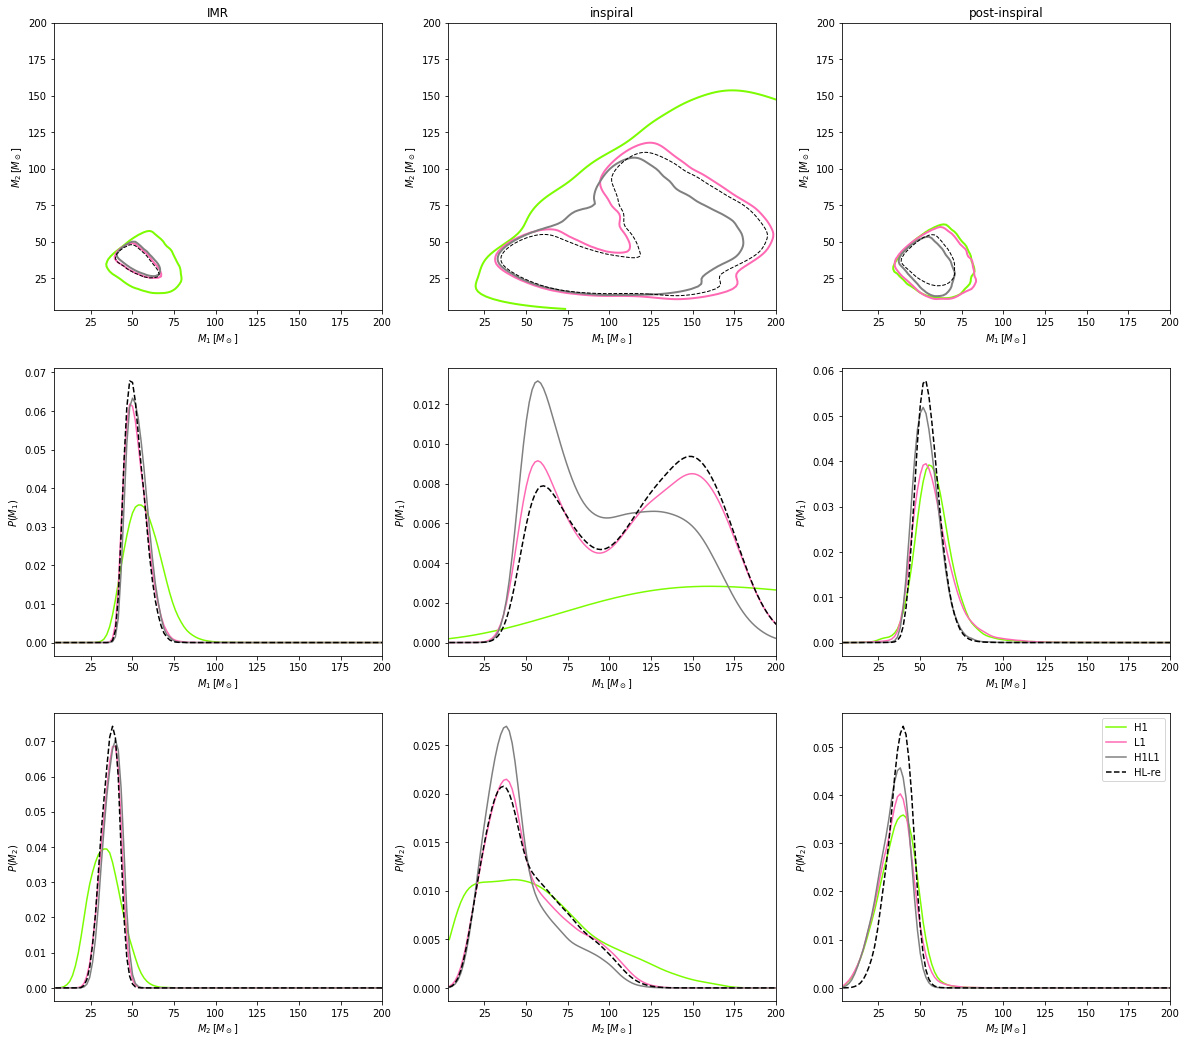

In [24]:
plt.figure(figsize=(20,18))
m_vec = np.linspace(3.91258703,858.96720526,500)
dm = np.mean(np.diff(m_vec))

# posterior distributions of chirp mass in H1, L1, and HL -- initialise 
P_m1 = {'H1':[], 'L1': [], 'H1L1': []}
P_m2 = {'H1':[], 'L1': [], 'H1L1': []}
P_m1m2 = {'H1':[], 'L1': [], 'H1L1': []}
col_vec = ['lawngreen','hotpink','gray']


for i_r, run in enumerate(['IMR', 'inspiral', 'post-inspiral']): 
#for i_r, run in e# Compare the network (Mc, t0) posterior with that reconstructed from individual detector runsnumerate(['IMR']): 

    print '...', run 
    for i_d, det in enumerate(['H1', 'L1', 'H1L1']):
        if det == 'H1' or det == 'L1':
            post_file = post_loc + '/%s/lalinferencenest/%s/1187529256.52-0/H1L1/%s/posterior_samples.dat'%(run, templ, det)
        elif det == 'H1L1':
            post_file = post_loc + '/%s/lalinferencenest/%s/1187529256.52-0/H1L1/posterior_samples.dat'%(run, templ)
         
        print '.....', det 
        data = np.genfromtxt(post_file, dtype=None, names=True)
        m1, m2, dlogL, logL, t0, ra, dec = data['m1'], data['m2'], data['deltalogl'], data['logl'], data['time'], data['ra'], data['dec']
        
        m_tot = m1+m2 
        q = m1/m2 
        eta = q/(1.+q)**2 
        m_c = m_tot*eta**(3./5)      
        t0 = t0-t0_ref     
        m2 = m_tot/(1.+ q)
        m1 = q*m_tot/(1.+q)
        
        # compute the 2D KDE of chirp mass, m1, m2 
        P_m1[det], P_m2[det], P_m1m2[det], s2_m1m2 = compte_kde(m1, m2, m_vec, m_vec)
          
        # normalize 
        P_m1[det] /= np.sum(P_m1[det]*dm)
        P_m2[det] /= np.sum(P_m2[det]*dm)
        P_m1m2[det] /= np.sum(P_m1m2[det])*dm*dm

        plt.subplot(3,3,i_r+1)
        plt.contour(m_vec, m_vec, P_m1m2[det], levels=(s2_m1m2,), linewidths=(2,), colors=(col_vec[i_d],))
        plt.xlabel('$M_{1} \, [M_\odot]$')
        plt.ylabel('$M_{2} \, [M_\odot]$')
        plt.ylim(3,200)
        plt.xlim(3,200)
        plt.title(run)
        
        plt.subplot(3,3,i_r+4)
        plt.plot(m_vec, P_m1[det], color=col_vec[i_d], label=det)
        plt.xlabel('$M_{1} \, [M_\odot]$')
        plt.ylabel('$P(M_{1})$') 
        plt.xlim(3,200)

        plt.subplot(3,3,i_r+7)
        plt.plot(m_vec, P_m2[det], color=col_vec[i_d], label=det)
        plt.xlabel('$M_{2} \, [M_\odot]$')
        plt.ylabel('$P(M_{2})$') 
        plt.xlim(3,200)
        
    # construct network posteriors from individual detectors 
    P_m1m2_HL_recons = P_m1m2['H1']*P_m1m2['L1']
    P_m1m2_HL_recons /= np.sum(P_m1m2_HL_recons)*dm*dm
    conf_v1v2 = confidence(P_m1m2_HL_recons)
    s2_v1v2 = conf_v1v2.height_from_level(0.9)
    
    # marginalize and normalize 
    P_m1_HL_recons = np.sum(P_m1m2_HL_recons, axis=0) * dm
    P_m2_HL_recons = np.sum(P_m1m2_HL_recons, axis=1) * dm
    P_m1_HL_recons /= np.sum(P_m1_HL_recons*dm)
    P_m2_HL_recons /= np.sum(P_m2_HL_recons*dm)

    # plot the network posteriors reconstructed from H and L runs 
    plt.subplot(3,3,i_r+1)
    plt.contour(m_vec, m_vec, P_m1m2_HL_recons, levels=(s2_m1m2,), linewidths=(1,), colors=('k',), linestyles=('--',))
    plt.subplot(3,3,i_r+4)
    plt.plot(m_vec, P_m1_HL_recons, ls='--', color='k', label='HL-re')
    plt.subplot(3,3,i_r+7)
    plt.plot(m_vec, P_m2_HL_recons, ls='--', color='k', label='HL-re')

plt.legend(frameon=True)
plt.savefig('posterior_kde_m1m2_%s_clean.png' %templ, dpi=300)
plt.show()

# Compare the network (Mc,q) posterior with that reconstructed from individual detector runs

In [25]:
# calculate the prior on Mc corresponding to a flat prior on m1, m2 
m1_pr = np.random.uniform(3.91258703, 858.96720526, 100000000)
m2_pr = np.random.uniform(3.91258703, 858.96720526, 100000000)
mc_pr = (m1_pr*m2_pr)**(3./5)*(m1_pr+m2_pr)**(-1./5)
mc_pr = mc_pr[np.logical_and(mc_pr > 12.299703, mc_pr < 150)]
P_mc_pr, mc_edg = np.histogram(mc_pr, bins=mc_vec, normed=True)
P_mc_pr = np.append(P_mc_pr, P_mc_pr[-1])

... IMR
..... H1
..... L1
..... H1L1
... inspiral
..... H1
..... L1
..... H1L1
... post-inspiral
..... H1
..... L1
..... H1L1


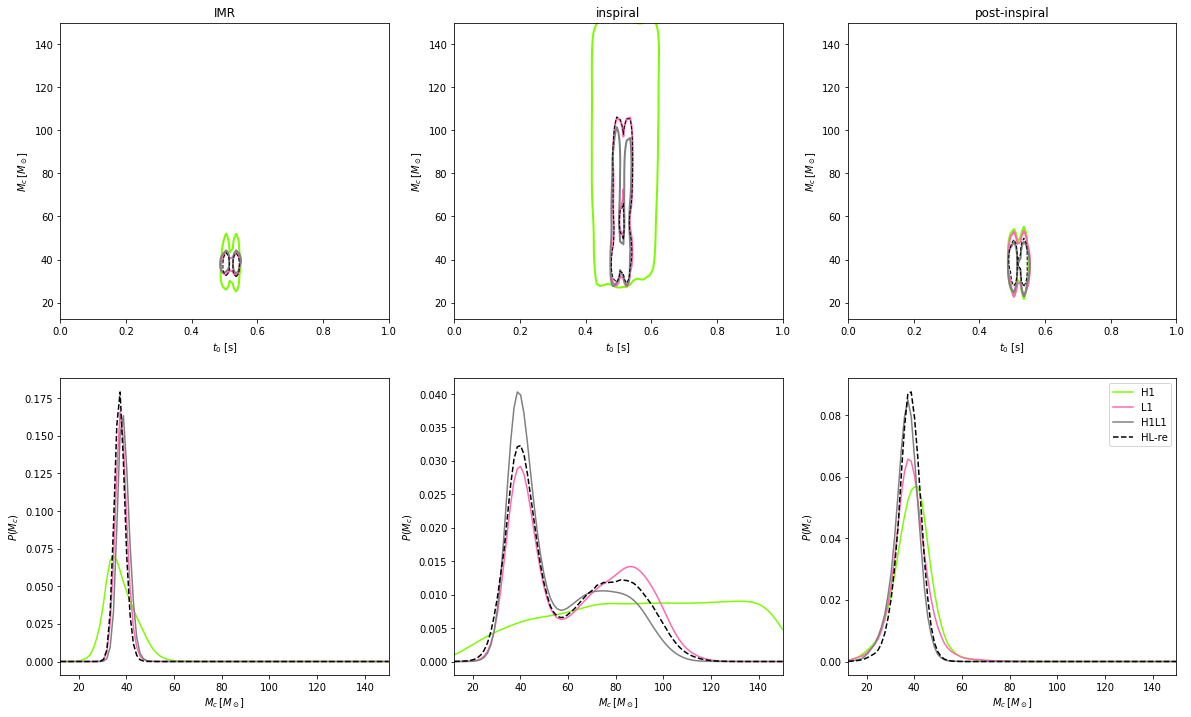

In [26]:
plt.figure(figsize=(20,12))
m_vec = np.linspace(12.299703,150,400)
q_vec = np.linspace(1,18,100)
t0_vec = np.linspace(0,1,100)
dmc = mc_vec[1]-mc_vec[0]
dt0 = t0_vec[1]-t0_vec[0]
    
# posterior distributions of chirp mass in H1, L1, V1, and LHV -- initialise 
P_mc = {'H1':[], 'L1': [], 'H1L1': []}
P_mct0 = {'H1':[], 'L1': [], 'H1L1': []}
col_vec = ['lawngreen','hotpink', 'gray']


for i_r, run in enumerate(['IMR', 'inspiral', 'post-inspiral']): 
#for i_r, run in e# Compare the network (Mc, t0) posterior with that reconstructed from individual detector runsnumerate(['IMR']): 

    print '...', run 
    for i_d, det in enumerate(['H1', 'L1', 'H1L1']):
        if det == 'H1' or det == 'L1':
            post_file = post_loc + '/%s/lalinferencenest/%s/1187529256.52-0/H1L1/%s/posterior_samples.dat'%(run, templ, det)
        elif det == 'H1L1':
            post_file = post_loc + '/%s/lalinferencenest/%s/1187529256.52-0/H1L1/posterior_samples.dat'%(run, templ)
         
        print '.....', det 
        data = np.genfromtxt(post_file, dtype=None, names=True)
        m1, m2, dlogL, logL, t0, ra, dec = data['m1'], data['m2'], data['deltalogl'], data['logl'], data['time'], data['ra'], data['dec']
        
        m_tot = m1+m2 
        q = m1/m2 
        eta = q/(1.+q)**2 
        m_c = m_tot*eta**(3./5)      
        t0 = t0-t0_ref     
        m2 = m_tot/(1.+ q)
        m1 = q*m_tot/(1.+q)
        
        # compute the 2D KDE of chirp mass, m1, m2 
        P_t0, P_mc[det], P_mct0[det], s2_mct0 = compte_kde(t0, m_c, t0_vec, mc_vec)
          
        # normalize 
        P_mc[det] /= np.sum(P_mc[det]*dmc)
        P_mct0[det] /= np.sum(P_mct0[det])*dmc*dt0

        plt.subplot(2,3,i_r+1)
        plt.contour(t0_vec, mc_vec, P_mct0[det], levels=(s2_mct0,), linewidths=(2,), colors=(col_vec[i_d],))
        plt.xlabel('$t_0$ [s]')
        plt.ylabel('$M_{c} \, [M_\odot]$')
        plt.ylim(12.299703,150)
        plt.title(run)
        
        plt.subplot(2,3,i_r+4)
        plt.plot(mc_vec, P_mc[det], color=col_vec[i_d], label=det)
        plt.xlabel('$M_{c} \, [M_\odot]$')
        plt.ylabel('$P(M_{c})$') 
        plt.xlim(12.299703,150)
        
    # construct network posteriors from individual detectors 
    P_mct0_HL_recons = P_mct0['H1']*P_mct0['L1']
    P_mct0_HL_recons /= np.sum(P_mct0_HL_recons)*dmc*dt0
    conf_v1v2 = confidence(P_mct0_HL_recons)
    s2_v1v2 = conf_v1v2.height_from_level(0.9)
    
    # marginalize and normalize 
    P_mc_HL_recons = np.sum(P_mct0_HL_recons, axis=1) * dt0
    P_mc_HL_recons /= P_mc_pr**2 # divide by the prior in Mc twice 
    P_mc_HL_recons /= np.sum(P_mc_HL_recons*dmc)

    # plot the network posteriors reconstructed from H and L runs 
    plt.subplot(2,3,i_r+1)
    plt.contour(t0_vec, mc_vec, P_mct0_HL_recons, levels=(s2_mct0,), linewidths=(1,), colors=('k',), linestyles=('--',))
    plt.subplot(2,3,i_r+4)
    plt.plot(mc_vec, P_mc_HL_recons, ls='--', color='k', label='HL-re')

plt.legend(frameon=True)
plt.savefig('posterior_kde_Mc_t0_%s_clean.png' %templ, dpi=300)
plt.show()

In [25]:
from pylal import Fr
from pycbc import frame

gpstime = 1187529256.5179
gpsstarttime = 1187529254
gpsendtime = 1187529258

H1_clean, H1_clean_channel = '../data/GW170823/H1_CLEANED_HOFT_C02.gwf', 'H1:DCH-CLEAN_STRAIN_C02'
L1_clean, L1_clean_channel = '../data/GW170823/L1_CLEANED_HOFT_C02.gwf', 'L1:DCH-CLEAN_STRAIN_C02'

H1_unclean, H1_unclean_channel = '../data/GW170823/H1_HOFT_C02.gwf', 'H1:DCS-CALIB_STRAIN_C02'
L1_unclean, L1_unclean_channel = '../data/GW170823/L1_HOFT_C02.gwf', 'L1:DCS-CALIB_STRAIN_C02'

H1_res, H1_res_channel = '../data/GW170823/H1_HOFT_RES.gwf', 'H1:residual'
L1_res, L1_res_channel = '../data/GW170823/L1_HOFT_RES.gwf', 'L1:residual'

hoft, gps_start, xoffset, dt, xunit, yunit = Fr.frgetvect(H1_unclean, H1_unclean_channel)
t = gps_start + np.arange(0., len(hoft))*dt
band_idx, = np.where((t > gpsstarttime) & (t < gpsendtime))
np.savetxt('../data/GW170823/H1_HOFT_C02-1187529256.dat', np.c_[t[band_idx], hoft[band_idx]])

hoft, gps_start, xoffset, dt, xunit, yunit = Fr.frgetvect(H1_clean, H1_clean_channel)
t = gps_start + np.arange(0., len(hoft))*dt
band_idx, = np.where((t > gpsstarttime) & (t < gpsendtime))
np.savetxt('../data/GW170823/H1_CLEANED_HOFT_C02-1187529256.dat', np.c_[t[band_idx], hoft[band_idx]])

hoft, gps_start, xoffset, dt, xunit, yunit = Fr.frgetvect(H1_res, H1_res_channel)
t = gps_start + np.arange(0., len(hoft))*dt
band_idx, = np.where((t > gpsstarttime) & (t < gpsendtime))
np.savetxt('../data/GW170823/H1_HOFT_RES-1187529256.dat', np.c_[t[band_idx], hoft[band_idx]])

hoft, gps_start, xoffset, dt, xunit, yunit = Fr.frgetvect(L1_unclean, L1_unclean_channel)
t = gps_start + np.arange(0., len(hoft))*dt
band_idx, = np.where((t > gpsstarttime) & (t < gpsendtime))
np.savetxt('../data/GW170823/L1_HOFT_C02-1187529256.dat', np.c_[t[band_idx], hoft[band_idx]])


hoft, gps_start, xoffset, dt, xunit, yunit = Fr.frgetvect(L1_clean, L1_clean_channel)
t = gps_start + np.arange(0., len(hoft))*dt
band_idx, = np.where((t > gpsstarttime) & (t < gpsendtime))
np.savetxt('../data/GW170823/L1_CLEANED_HOFT_C02-1187529256.dat', np.c_[t[band_idx], hoft[band_idx]])

hoft, gps_start, xoffset, dt, xunit, yunit = Fr.frgetvect(L1_res, L1_res_channel)
t = gps_start + np.arange(0., len(hoft))*dt
band_idx, = np.where((t > gpsstarttime) & (t < gpsendtime))
np.savetxt('../data/GW170823/L1_HOFT_RES-1187529256.dat', np.c_[t[band_idx], hoft[band_idx]])

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from scipy import interpolate
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from pylal import Fr
#from pycbc import frame

# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

... i =  0
... whitened data
... bandpassed data
... i =  1
... whitened data
... bandpassed data


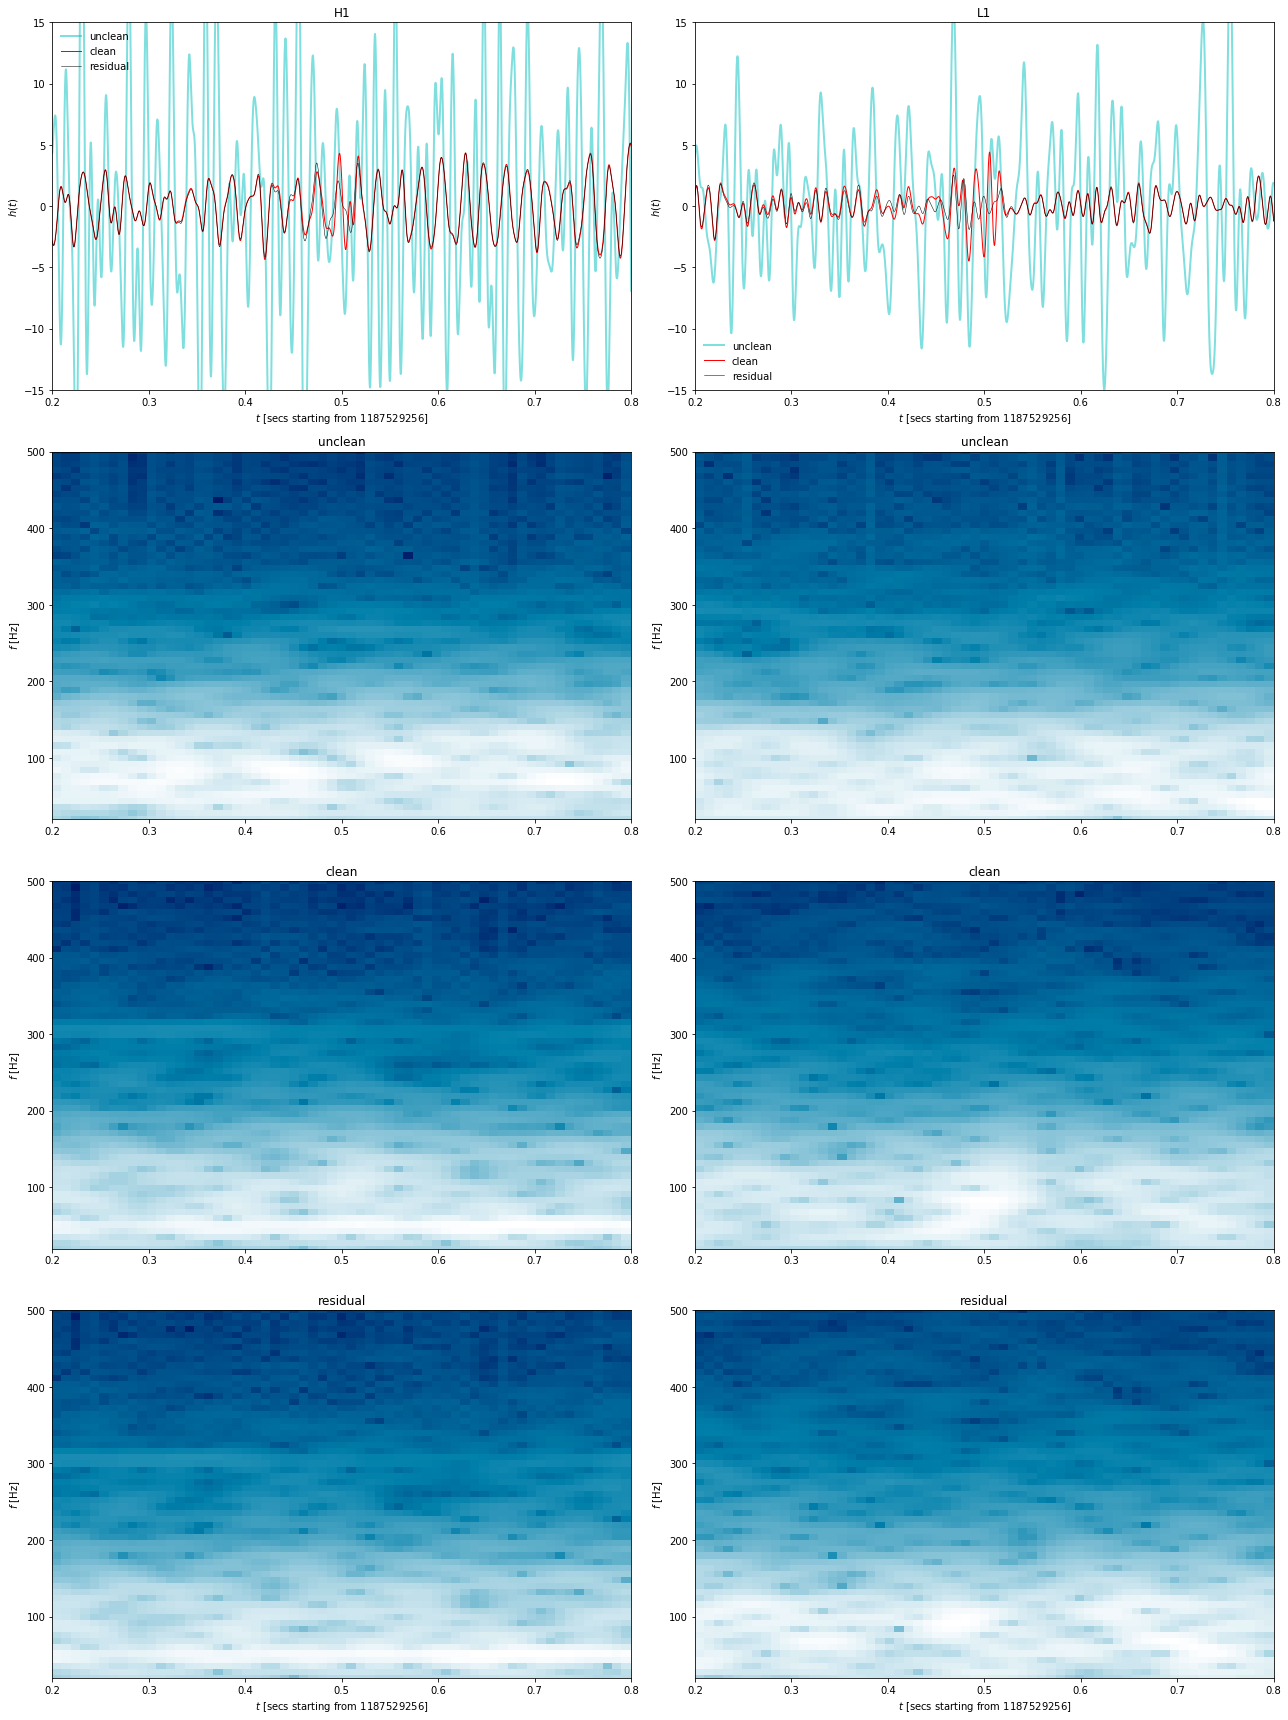

In [7]:
plt.figure(figsize=(18,24))

for i, ifo in enumerate(['H1','L1']):
    
    print '... i = ', i
    
    t_c, h_c = np.loadtxt('../data/GW170823/%s_CLEANED_HOFT_C02-1187529256.dat'%ifo, unpack=True)
    t_u, h_u = np.loadtxt('../data/GW170823/%s_HOFT_C02-1187529256.dat'%ifo, unpack=True)
    t_r, h_r = np.loadtxt('../data/GW170823/%s_HOFT_RES-1187529256.dat'%ifo, unpack=True)
    
    f_c, psd_c = np.loadtxt('../data/GW170823/BayesWave_%s_medianPSD_GW170823_8s_C02clean.dat'%ifo, unpack=True)
    f_u, psd_u = np.loadtxt('../data/GW170823/LALInfPSD_%s_GW170823_8s_C02unclean.dat'%ifo, unpack=True)

    t0 = 1187529256
    t_c -= t0
    t_u -= t0
    t_r -= t0
    
    psd_c_interp = interpolate.interp1d(f_c, psd_c, bounds_error=False,fill_value=(psd_c[0],psd_c[-1]))
    psd_u_interp = interpolate.interp1d(f_u, psd_u, bounds_error=False,fill_value=(psd_u[0],psd_u[-1]))

    fnew = np.linspace(0, 8192, 10000)
    
    dt = np.mean(np.diff(t_c))
    fs = 1/dt
    fband = [20, 120]
    tmin, tmax = 0.2, .8

    # whiten the data 
    h_c_w = whiten(h_c, psd_c_interp, dt)
    h_u_w = whiten(h_u, psd_u_interp, dt)
    h_r_w = whiten(h_r, psd_c_interp, dt)
    
    print '... whitened data'

    # band pass the data 
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    h_c_w = filtfilt(bb, ab, h_c_w) / normalization
    h_u_w = filtfilt(bb, ab, h_u_w) / normalization
    h_r_w = filtfilt(bb, ab, h_r_w) / normalization
    
    print '... bandpassed data'
    
    # plot the whitenened timeseries data 
    plt.subplot(4,2,i+1)
    plt.plot(t_u, h_u_w, color='c', label='unclean', lw=2, alpha=0.5)
    plt.plot(t_c, h_c_w, color='r', lw=1, label='clean')
    plt.plot(t_r, h_r_w, color='k', lw=0.5, label='residual')
    plt.title(ifo)
    plt.xlim(tmin, tmax)
    plt.ylim(-15,15)
    plt.ylabel('$h(t)$')
    plt.xlabel('$t$ [secs starting from %s]' %t0)
    plt.legend(frameon=False, loc=0)

    indxt = np.where((t_c >= tmin) & (t_c < tmax))

        
    # plot the spectrogram of whitened data 
    nfft = int(fs/8)
    novl = int(nfft*15./16)
    window = np.blackman(nfft)
    spec_cmap='ocean'

    plt.subplot(4,2,i+3)
    spec_u, freqs, bins, im = plt.specgram(h_u_w[indxt], NFFT=nfft, Fs=fs, Fc=0,
             window=window, noverlap=novl,
             cmap=spec_cmap, xextent=[tmin, tmax])
    plt.title('unclean')
    plt.ylabel('$f$ [Hz]')

    plt.ylim(20,500)

    plt.subplot(4,2,i+5)
    spec_c, freqs, bins, im = plt.specgram(h_c_w[indxt], NFFT=nfft, Fs=fs, Fc=0,
             window=window, noverlap=novl,
             cmap=spec_cmap, xextent=[tmin, tmax], pad_to=None, sides='default',
             scale_by_freq=None, mode='magnitude', scale='default')
    plt.title('clean')
    plt.ylim(20,500)
    plt.ylabel('$f$ [Hz]')


    plt.subplot(4,2,i+7)
    spec_r, freqs, bins, im = plt.specgram(h_r_w[indxt], NFFT=nfft, Fs=fs, Fc=0,
             window=window, noverlap=novl,
             cmap=spec_cmap, xextent=[tmin, tmax], pad_to=None, sides='default',
             scale_by_freq=None, mode='magnitude', scale='default')
    plt.title('residual')
    plt.ylim(20,500)
    plt.ylabel('$f$ [Hz]')
    plt.xlabel('$t$ [secs starting from %s]' %t0)
    
    if i == 1:
        plt.tight_layout()
        plt.savefig('../data/GW170823/timeseries_and_spectrogram_zoom.pdf')
        plt.savefig('../data/GW170823/timeseries_and_spectrogram_zoom.png', dpi=200)
        plt.show()